In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2025-05-24 12:42:45--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.1s    

2025-05-24 12:42:46 (1.49 MB/s) - ‘names.txt’ saved [228145/228145]



In [ ]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [ ]:
len(words)

32033

In [ ]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [ ]:
block_size = 3 ## the memory
def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


## Batch normalization
Batch Normalization (BatchNorm) is a layer you insert into your network—typically between the linear (or convolutional) transform and the activation—that does two things:
- Normalize each feature to zero mean and unit variance (over the current mini-batch) -> gaussian standard
- Learn a per-feature scale and shift so the network can still represent whatever distribution it needs

Stabilizes the distribution of activations (“internal covariate shift”), so each layer sees inputs that stay on a roughly consistent scale as training progresses.

In [ ]:
n_embd = 10 # dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size,n_embd),generator=g) #embedding table
## kaiming init (5/3) / (n_embd*block_size)
W1 = torch.randn((n_embd * block_size,n_hidden),generator=g) * ((5/3)/ (n_embd*block_size)**0.5) ## avoid tanh to be too saturated, standard deviation of .2
W2 = torch.randn((n_hidden,vocab_size),generator=g) * 0.01
b2 = torch.randn(vocab_size,generator=g) * 0

##make them trainable, so for each gradient descent it is being optimized
bngain = torch.ones((1,n_hidden))
bnbias = torch.zeros((1,n_hidden))
bnmean_running = torch.zeros((1,n_hidden))
bnstd_running = torch.ones((1,n_hidden))

parameters = [C,W1,b1,W2,b2,bngain,bnbias]

print(sum(p.nelement() for p in parameters))

for p in parameters:
  p.requires_grad = True

12297


In [ ]:
C.shape ## each token has a 10th dimensional vector

torch.Size([27, 10])

In [ ]:
  ix = torch.randint(0, Xtr.shape[0], (32,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

In [ ]:
Xb.shape

torch.Size([32, 3])

In [ ]:
C[Xb].shape # Each example has a 3 tokens as context. Then each token has 10th dimensions

torch.Size([32, 3, 10])

In [ ]:
emb = C[Xb] #index embedding table
embcat = emb.view(emb.shape[0],-1) #concate the vectors
embcat.shape # You join the examples of the mini batch with a single vector of 30 dimensions


## flattening the per-token embeddings (3 tokens × 10 dims each) into one long feature vector of length 30, so your linear layer can treat each example as a single 30-dimensional input

torch.Size([32, 30])

In [ ]:
## kaiming normal and fan in
import math
import torch
import torch.nn as nn
from torch.nn import init

layer = nn.Linear(in_features=256, out_features=128) ## Create a linear layer

# 1. gain for tanh
gain = init.calculate_gain('tanh')           # ≈1.6667

# 2. fan-in
fan_in, _ = init._calculate_fan_in_and_fan_out(layer.weight)

In [ ]:
(embcat @ W1).shape ## [32,30] X [32,200]-> [32,200]

torch.Size([32, 200])

In [ ]:
with torch.no_grad():
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0],-1)
  hpreact = embcat @ W1 + b1
  bnmean = hpreact.mean(0,keepdim=True)
  bnstd = hpreact.std(0,keepdim=True)

In [ ]:
max_steps = 200000
batch_size = 32
lossi = []
for i in range(max_steps):

  #minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y


  #forward pass

  #embedding table
  emb = C[Xb] #index embedding table
  embcat = emb.view(emb.shape[0],-1) #concate the vectors

  ##layer 1
  hpreact = embcat @ W1 ##preactivation linearity, bias is not necessary hence we have bnbias
  bnmeani = hpreact.mean(0,keepdim=True)
  bnstdi = hpreact.std(0,keepdim=True)
  hpreact =bngain * (hpreact - bnmeani) / bnstdi + bnbias ## batch norm

  with torch.no_grad():
    # Is optimized but not with gradient descent
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

  ## Batch normalization makes every neuron gaussian
  h = torch.tanh(hpreact) ## activation function


  #layer 2
  logits = h @ W2 + b2 ## linearity

  ## calculate the loss
  loss = F.cross_entropy(logits, Yb) # loss function

  ## backpropagation
  for p in parameters:
    p.grad = None ## zero grad

  loss.backward()
  #Update
  lr = 0.1 if i < 100000 else 0.01 #learning rate decay
  for p in parameters:
    p.data += -lr *p.grad

  #track stats
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.2f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.30
  10000/ 200000: 2.00
  20000/ 200000: 2.00
  30000/ 200000: 2.09
  40000/ 200000: 2.26
  50000/ 200000: 2.14
  60000/ 200000: 2.06
  70000/ 200000: 2.36
  80000/ 200000: 2.36
  90000/ 200000: 2.21
 100000/ 200000: 2.31
 110000/ 200000: 1.89
 120000/ 200000: 2.23
 130000/ 200000: 2.02
 140000/ 200000: 1.78
 150000/ 200000: 2.38
 160000/ 200000: 2.25
 170000/ 200000: 1.78
 180000/ 200000: 1.95
 190000/ 200000: 2.28


(array([496., 220., 170., 136., 128., 131., 123.,  82., 124.,  86.,  98.,
         93.,  74.,  77.,  81., 102.,  99., 101.,  84., 102.,  81., 114.,
        142., 103., 116., 105., 102., 122., 135., 118.,  95., 103.,  86.,
         93.,  94.,  95.,  84., 112., 104., 108.,  98.,  97., 134., 120.,
        111., 135., 145., 200., 236., 405.]),
 array([-9.99979258e-01, -9.59980354e-01, -9.19981451e-01, -8.79982548e-01,
        -8.39983644e-01, -7.99984741e-01, -7.59985838e-01, -7.19986935e-01,
        -6.79988031e-01, -6.39989128e-01, -5.99990225e-01, -5.59991322e-01,
        -5.19992418e-01, -4.79993515e-01, -4.39994612e-01, -3.99995708e-01,
        -3.59996805e-01, -3.19997902e-01, -2.79998999e-01, -2.40000095e-01,
        -2.00001192e-01, -1.60002289e-01, -1.20003386e-01, -8.00044823e-02,
        -4.00055790e-02, -6.67572021e-06,  3.99922276e-02,  7.99911308e-02,
         1.19990034e-01,  1.59988937e-01,  1.99987841e-01,  2.39986744e-01,
         2.79985647e-01,  3.19984550e-01,  3.59983

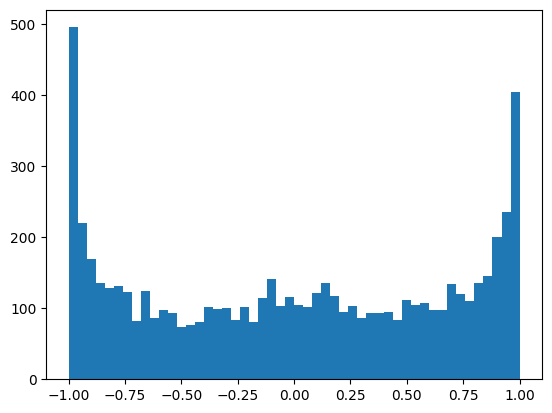

In [ ]:
plt.hist(h.view(-1).tolist(), 50)

(array([  2.,   2.,   2.,   5.,   8.,   4.,   7.,  10.,   6.,  12.,  21.,
         29.,  50.,  61.,  82.,  96., 108., 130., 175., 187., 247., 295.,
        350., 389., 515., 629., 595., 426., 401., 326., 247., 217., 189.,
        145., 109.,  92.,  63.,  45.,  39.,  22.,  21.,  18.,   8.,   5.,
          5.,   0.,   1.,   0.,   1.,   3.]),
 array([-5.73752117, -5.51297969, -5.28843821, -5.06389672, -4.83935524,
        -4.61481376, -4.39027227, -4.16573079, -3.94118931, -3.71664783,
        -3.49210634, -3.26756486, -3.04302338, -2.81848189, -2.59394041,
        -2.36939893, -2.14485744, -1.92031596, -1.69577448, -1.471233  ,
        -1.24669151, -1.02215003, -0.79760855, -0.57306706, -0.34852558,
        -0.1239841 ,  0.10055738,  0.32509887,  0.54964035,  0.77418183,
         0.99872332,  1.2232648 ,  1.44780628,  1.67234776,  1.89688925,
         2.12143073,  2.34597221,  2.5705137 ,  2.79505518,  3.01959666,
         3.24413815,  3.46867963,  3.69322111,  3.91776259,  4.14230408,
 

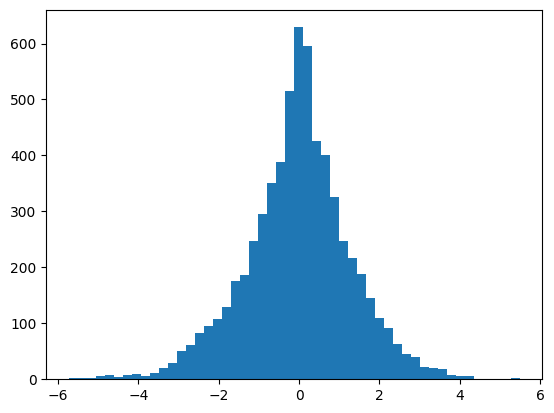

In [ ]:
plt.hist(hpreact.view(-1).tolist(), 50)

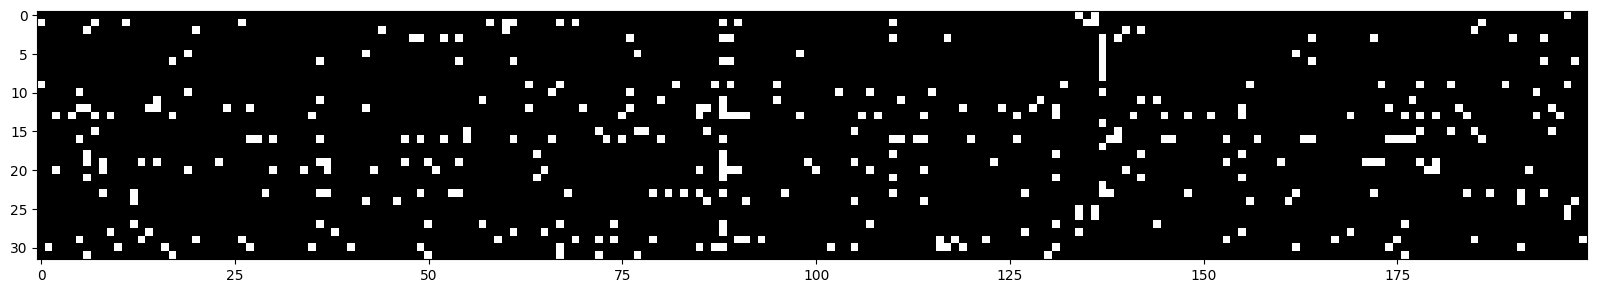

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

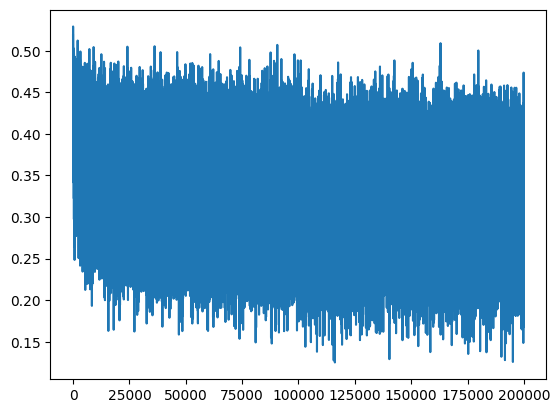

In [ ]:
plt.plot(lossi)

In [ ]:
@torch.no_grad()
def split_loss(split):
  x,y ={
      'train': (Xtr,Ytr),
      'val': (Xdev,Ydev),
      'test': (Xte,Yte)
  }[split]
  emb = C[x]
  embcat = emb.view(emb.shape[0],-1)
  h = torch.tanh(embcat @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits,y)
  print(split,loss.item())

split_loss('train')
split_loss('val')

train 2.98024845123291
val 3.0077786445617676


In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
  out = []
  context = [0] * block_size
  while True:
    emb = C[torch.tensor([context])]
    h = torch.tanh(emb.view(1,-1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits,dim=1)
    #sample from the distribution
    ix = torch.multinomial(probs,num_samples=1,generator=g).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break

  print(''.join(itos[i] for i in out))

briangmyah.
sebnfedh.
saldrethruthndra.
frazshedgelisselgprdus.
den.
santhannchyziohmkrrnn.
shdumrishimnest.
jabrwillissabhudfk.
bdulcdem.
jaquezmashburjahsis.
dashby.
sadya.
sus.
zakquslutel.
subristia.
sumprrdnn.
qulyah.
sgbpriczoumusziahhmrettlia.
sirfalvinnwrllwildtalfr.
tandysirthalissa.
